In [1]:
from main import *
import numpy as np
import pandas as pd

# parameter setup

In [2]:
target_feature = "merged_support3_variance_0.1_random_1M"
target_feature_suffix = "_matrix.npy"
save_data_path = "./results"

select_methods = ["rf"]# ["random", "xgb", "rf", "variance", "chi2", "f_classif"] # Extra-trees # "mutual_info_classif"
    
n_select_list = [256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072] #5105448
n_dim_reduce_list = [128, 256, 512, 1024, None]  ## list should always contain None to perform whole feature training after selection
ML_models = ["SVM"] #["SVM", "XGB", "RF", "DT", "KNN"]

# data loading

In [3]:
feature_data_path, sample_annotation_file = get_data_path(save_data_path)

In [4]:
dataset = data_loader(os.path.join(feature_data_path, target_feature + target_feature_suffix), 
                        sample_annotation_file)
(X, y_original, y), (train_indices, val_indices, test_indices), label_mapping = dataset.get_data()


result_combined = []

2024-05-27 14:59:17,966 - INFO - [progress] Read data done. X.shape: (3202, 1048576), y.shape: (3202,)
2024-05-27 14:59:18,561 - INFO - [progress] Dropped 1 samples from the dataset. X.shape: (3201, 1048576), y.shape: (3201,)
2024-05-27 14:59:32,068 - INFO -  - Data_split: train_set (n= 1920), val_set (n= 640), test_set (n= 641)


# save feature selection result

In [ ]:
n = 8192
save_file_name = os.path.join(feature_data_path, target_feature + f"_xgb_{n}" + target_feature_suffix)

X = np.load(os.path.join(feature_data_path, target_feature + target_feature_suffix))
feature_importance_use = np.load(f"1048576_seed42_xgb_basic_feature_importance_mean.npy")
selected_indices = np.argsort(feature_importance_use)[-n:][::-1]
X_selected = X[:, selected_indices]
np.save(save_file_name, X_selected)

print(f"saved result to {save_file_name} with shape {X_selected.shape}")

# Prepare geography plot

In [5]:
sample_annotation_df = pd.read_csv(sample_annotation_file, sep="\t")

In [6]:
cls_code_to_name = sample_annotation_df[["Population code", "Population name"]].drop_duplicates().reset_index(drop= True)
cls_code_to_name

,Population code,Population name
0,FIN,Finnish
1,FIN,"Finnish,Finnish"
2,GBR,British
3,CHS,Southern Han Chinese
4,PUR,Puerto Rican
5,CDX,Dai Chinese
6,CLM,Colombian
7,IBS,"Iberian,Spanish"
8,IBS,Iberian
9,KHV,Kinh Vietnamese


In [7]:
locations = {
    'FIN': (25.0, 60.0),  # Finnish
    'GBR': (-0.1276, 51.5074),  # British,English
    'CHS': (113.7633, 22.18),  # Southern Han Chinese
    'PUR': (-66.1057, 18.4655),  # Puerto Rican
    'CDX': (100.212, 22.0000),  # Dai Chinese
    'CLM': (-74.0817, 4.7110),  # Colombian
    'IBS': (-3.7492, 40.4637),  # Iberian,Spanish
    'KHV': (105.8542, 21.0285),  # Kinh Vietnamese
    'PEL': (-77.0428, -12.0464),  # Peruvian
    'PJL': (74.3587, 31.5204),  # Punjabi
    'ACB': (-61.2225, 10.6918),  # African Caribbean
    'GWD': (-15.3101, 13.4432),  # Gambian Mandinka
    'ESN': (6.6745, 6.7439),  # Esan
    'BEB': (90.4125, 23.8103),  # Bengali
    'MSL': (-11.7383, 7.9647),  # Mende
    'ITU': (78.4867, 17.3850),  # Telugu
    'STU': (80.2707, 13.0827),  # Tamil
    'CEU': (2.3522, 48.8566),  # CEPH
    'YRI': (3.9470, 7.3775),  # Yoruba
    'CHB': (116.4074, 39.9042),  # Han Chinese
    'JPT': (139.6917, 35.6895),  # Japanese
    'LWK': (34.7519, 0.2827),  # Luhya
    'MXL': (-99.1332, 19.4326),  # Mexican Ancestry
    'ASW': (-118.2437, 34.0522),  # African Ancestry SW
    'TSI': (11.2558, 43.7696),  # Toscani
    'GIH': (72.5714, 23.0225)  # Gujarati
}  # Population code -> (longitude, latitude)
color_palette = ["#2A363B", "#355C7D", "#99B898", "#E84A5F", "#FF847C", "#FECEAB"]

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Wedge, Circle

def draw_pie_charts_on_map(cities, save_file_name = None):
    """
    주어진 도시 목록에 대해 고해상도 세계지도 위에 파이 차트를 그립니다.

    Parameters:
    cities (list of dicts): 도시 정보를 담고 있는 리스트. 각 항목은 다음 키를 가짐:
        - name (str): 도시 이름
        - lon (float): 경도
        - lat (float): 위도
        - value (float): 파이 차트에서 첫 번째 조각의 비율
        - radius (float): 파이 차트의 크기
    """
    start_angle = 0

    # 평면 지도 생성
    fig, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_global()

    # High-resolution coastlines and borders
    coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '110m', edgecolor='black', facecolor='none', linewidth=0.5)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '110m', edgecolor='black', facecolor='none', linewidth=0.2)
    ax.add_feature(coastline)
    ax.add_feature(borders)
    ax.add_feature(cfeature.LAND, color='lightgrey')
    ax.add_feature(cfeature.OCEAN, color='white')

    radius_normalize = np.mean([city["radius"] for city in cities]) / 4
    # 각 도시에 대해 파이 차트 그리기
    for city in cities:
        if "th2" in city:
            sizes = [city['th1'], city['th2'], 1-city['th1']-city['th2']]  # Proportions for the pie chart
            colors = [color_palette[1], color_palette[2], color_palette[3]]  # Colors for train, validation, and test
        else:
            sizes = [city['th1'], 1 - city['value']]  # 파이 차트 비율
            colors = [(1, 0, 0, 0.5), 'grey']  # 빨간색과 회색
        for size, color in zip(sizes, colors):
            angle = 360 * size
            wedge = Wedge(center=(city['lon'], city['lat']), r=city['radius'] / radius_normalize,
                          theta1=start_angle, theta2=start_angle + angle,
                          edgecolor='white', facecolor=color, transform=ccrs.Geodetic())
            ax.add_patch(wedge)
            start_angle += angle
        # ax.text(city['lon'], city['lat'], city['name'], fontsize=8, ha='center', transform=ccrs.Geodetic())

    # Add legend
    train_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette[1], markersize=10, label='Train')
    val_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette[2], markersize=10, label='Validation')
    test_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_palette[3], markersize=10, label='Test')
    plt.legend(handles=[train_patch, val_patch, test_patch], loc='lower left')

    # Add legend for circle sizes
    max_radius = max(city['radius'] for city in cities)
    min_radius = min(city['radius'] for city in cities)
    legend_sizes = np.arange(100, max_radius + 50, 50)#np.linspace(min_radius, max_radius, num=3)

    for i, r in enumerate(legend_sizes):
        circ = Circle((-170, -60 + i * 12), radius=r / radius_normalize, edgecolor='black', facecolor='lightgrey', transform=ccrs.Geodetic())
        ax.add_patch(circ)
        plt.text(-160, -60 + i * 12, f'{int(r)} samples', fontsize=10, ha='left', va='bottom', transform=ccrs.Geodetic())

            
    if save_file_name is not None:
        plt.savefig(save_file_name, dpi = 300)
    plt.show()


# Fig1. Dataset description

In [9]:
y_train, y_val, y_test = y_original[train_indices], y_original[val_indices], y_original[test_indices]

In [10]:
total_counts = pd.DataFrame(y_original, columns=["class_label"]).value_counts().reset_index(name='Total_Count')
train_counts = pd.DataFrame(y_train, columns=["class_label"]).value_counts().reset_index(name='Train_Count')
val_counts = pd.DataFrame(y_val, columns=["class_label"]).value_counts().reset_index(name='Val_Count')
test_counts = pd.DataFrame(y_test, columns=["class_label"]).value_counts().reset_index(name='Test_Count')

# Merge the counts into a single dataframe
combined_counts = pd.merge(total_counts, train_counts, on='class_label', how='outer')
combined_counts = pd.merge(combined_counts, val_counts, on='class_label', how='outer')
combined_counts = pd.merge(combined_counts, test_counts, on='class_label', how='outer')


In [11]:
combined_counts

,class_label,Total_Count,Train_Count,Val_Count,Test_Count
0,CEU,179,107,36,36
1,YRI,178,107,35,36
2,GWD,178,107,35,36
3,CHS,163,98,32,33
4,IBS,156,94,31,31
5,ESN,149,89,30,30
6,PJL,146,88,29,29
7,PUR,139,83,28,28
8,CLM,132,80,26,26
9,BEB,131,79,26,26


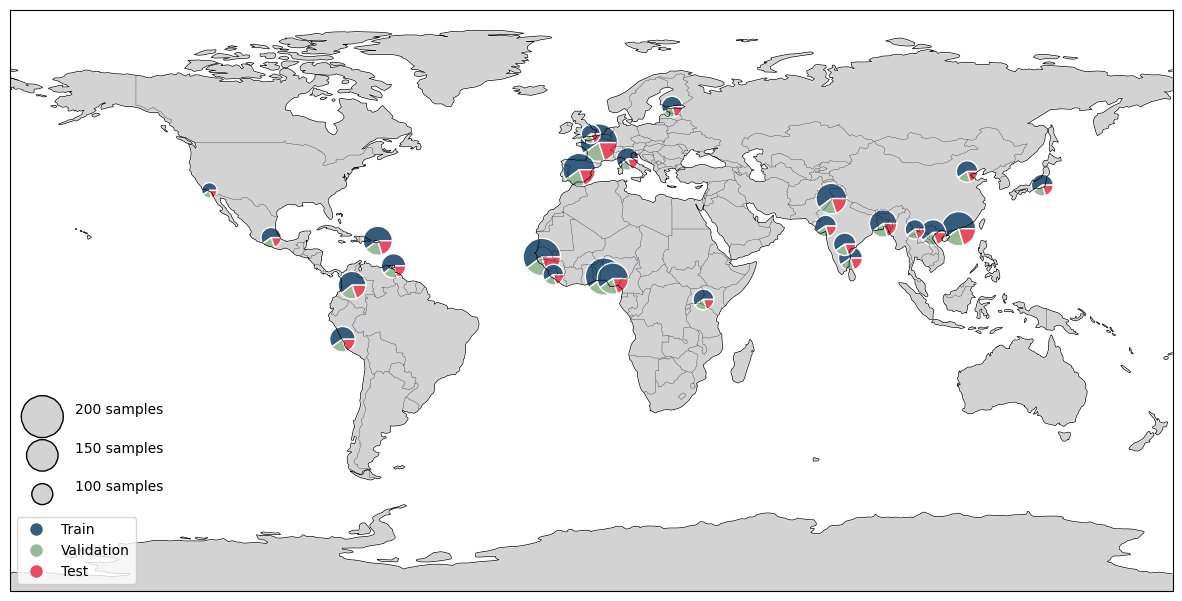

In [12]:
cities = []
for idx, row in combined_counts.iterrows():
    code = row['class_label']
    if code in locations:
        lon, lat = locations[code]
        city = {
            'name': code,
            'lon': lon,
            'lat': lat,
            'th1': row["Train_Count"] / row["Total_Count"],  # This is an arbitrary placeholder, adjust as necessary
            'th2': row["Val_Count"] / row["Total_Count"],  # This is an arbitrary placeholder, adjust as necessary
            'radius': row["Total_Count"],#  # Normalize by the largest possible value for visualization scaling
        }
        cities.append(city)
    else:
        print(code)


draw_pie_charts_on_map(cities, "results/data_description.pdf")

# Fig4. Number of features required for classifying each class

In [ ]:
df_minimum_n_by_cls = pd.read_csv("results/minimum_n_by_cls.csv")


In [ ]:
standard_class = "FIN"
standard_n = df_minimum_n_by_cls[df_minimum_n_by_cls["class_target"] == standard_class]["select_n"].iloc[0]

feature_importance_standard = np.load(f"8192_seed42_xgb_cls_{standard_class}_basic_feature_importance_mean.npy")
selected_indices_standard = np.argsort(feature_importance_standard)[-standard_n:][::-1]

In [ ]:
selected_indices_standard

In [ ]:
overlab_dict = {}

for i, r in df_minimum_n_by_cls.iterrows():
    current_class = r["class_target"]
    current_n = r["select_n"]
    if current_class == standard_class:
        overlab_dict[current_class] = 1
    feature_importance_current = np.load(f"8192_seed42_xgb_cls_{current_class}_basic_feature_importance_mean.npy")
    selected_indices_current = np.argsort(feature_importance_current)[-current_n:][::-1]
    intersection = np.intersect1d(selected_indices_standard, selected_indices_current)
    overlab_dict[current_class] = len(intersection) / current_n


In [ ]:
# Generate cities data list from the dataframe and location dictionary
cities = []
for idx, row in df_minimum_n_by_cls.iterrows():
    code = row['class_target']
    if code in locations:
        lon, lat = locations[code]
        city = {
            'name': code,
            'lon': lon,
            'lat': lat,
            'value': overlab_dict[code],  # This is an arbitrary placeholder, adjust as necessary
            'radius': np.log10(row['select_n'] / 8192 * 10000)  # Normalize by the largest possible value for visualization scaling
        }
        cities.append(city)
    else:
        print(code)

# cities = [
#     # {'name': 'New York', 'lon': -74, 'lat': 40, 'value': 0.7, 'radius': 5},
#     # {'name': 'London', 'lon': -0.1276, 'lat': 51.5074, 'value': 0.6, 'radius': 5},
#     # {'name': 'Tokyo', 'lon': 139.6917, 'lat': 35.6895, 'value': 0.8, 'radius': 5},
#     # {'name': 'Sydney', 'lon': 151.2093, 'lat': -33.8688, 'value': 0.5, 'radius': 5},
#     # {'name': 'Paris', 'lon': 2.3522, 'lat': 48.8566, 'value': 0.65, 'radius': 5},
#     # {'name': 'Moscow', 'lon': 37.6173, 'lat': 55.7558, 'value': 0.75, 'radius': 5},
#     # {'name': 'Beijing', 'lon': 116.4074, 'lat': 39.9042, 'value': 0.55, 'radius': 5},
#     # {'name': 'Cairo', 'lon': 31.2357, 'lat': 30.0444, 'value': 0.6, 'radius': 5},
#     # {'name': 'Buenos Aires', 'lon': -58.3816, 'lat': -34.6037, 'value': 0.7, 'radius': 5},
#     # {'name': 'Los Angeles', 'lon': -118.2437, 'lat': 34.0522, 'value': 0.65, 'radius': 5},
# ]

draw_pie_charts_on_map(cities)